<a href="https://colab.research.google.com/github/yschimpf/feedback_alignment/blob/main/code/version_with_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np

In [91]:
class NeuralNetwork(object):
  #layers include input and output layer, activiation allows for an activation
  #to allow for f.e. softmax in case of application
  # Losses: Allows for MSE and Cross-Entropy loss. For cross entropy loss the
  #   y's are to be given as one hot encodings. As of now for the MSE the last
  #   layer is assumed to have idetntity activation
  # Activations: Supports Sigmoid, identity, relu, and softmax
  #   Softmax is only supported to be applied in the last layer for multiclass
  #   classification.
  def __init__(self, layers = [2,10,1], activations = ['sigmoid','identity'], loss = 'MSE'):
    assert(len(layers) == len(activations)+1)
    self.layers = layers
    self.activations = activations
    self.loss = loss
    self.weights = []
    self.biases = []
    self.errors = [] #used for error plotting
    #fill the matrices with random values
    for i in range (len(layers)-1):
      self.weights.append(np.random.randn(layers[i+1], layers[i]))
      self.biases.append(np.random.randn(layers[i+1], 1))

    # computation of all unit inputs and activations fpr all layers
  def feedforward(self, x):
    #first layer has no activation function
    v = np.copy(x)
    z_s = []
    v_s = [v]
    #for all other leayers compute the weighted inputs of last layer units
    #and apply activations. Last layer has activation to f.e. apply softmax
    for i in range(len(self.weights)):
      activation = self.getActivationFunction(self.activations[i])
      #print(i)
      #print(self.weights[i].shape)
      #print(v.shape)
      z_s.append(self.weights[i].dot(v)+self.biases[i])
      v = activation(z_s[-1])
      v_s.append(v)
    return (z_s, v_s)


  #gets labels and feedforward data
  #returns derivatives w.r.t. weight matrices
  def backpropagation(self, y, z_s, v_s):
    #derivatives with respect to the weighs
    dw = []
    #error backprogated through the layers i.e. dL/dz i.e. error
    #in terms of inputs to the respective layer
    deltas = [None]*len(self.weights)
    #error in terms of inputs of last layer => different computation for MSE and L_CE
    deltas[-1] = (self.getDerivativeLoss(self.loss)(v_s[-1], y)) #* (self.getDerivativeActivation(self.activations[-1])(z_s[-1]))
    #actual backpropagation
    for i in reversed(range(len(deltas)-1)):
      #compute dL/dz for each layer that is the loss in terms of the inputs of the activation
      deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivativeActivation(self.activations[i])(z_s[i]))
    batch_size = y.shape[1]
    #compute dL/dw for all weight matrices
    dw = [d.dot(v_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
    #compute dL/db for all biases
    db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for i,d in enumerate(deltas)]
    return dw, db

  #train netowrk on the training data
  def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
    for e in range (epochs):
      i = 0
      while(i < len(y)):
        x_batch = x[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        i = i+batch_size
        z_s, v_s = self.feedforward(x_batch)
        dw, db = self.backpropagation(y_batch, z_s, v_s)
        self.weights = [w - lr*dweight for w,dweight in zip(self.weights, dw)]
        self.biases = [b - lr*dbias for b,dbias in zip(self.biases, db)]
        if(e%100 == 0): print("loss ={}".format(np.linalg.norm(v_s[-1]-y_batch)))
      self.errors.append(self.getLoss(self.loss)(v_s[-1],y_batch))

  #prediction for classification
  def predict(self, X):
    _, f = self.feedforward(X)
    #print((f[-1]).T)
    pred = np.argmax(f[-1], axis=0)
    #print(pred)
    return pred

  #definition of nonlinearities for units
  @staticmethod
  def getActivationFunction(name):
    if(name == 'sigmoid'):
      return lambda x : np.exp(x)/(1+np.exp(x))
    elif(name == 'identity'):
      return lambda x : x
    elif(name == 'relu'):
      def relu(x):
        y = np.copy(x)
        if(y<0):
          return 0
        else:
          return y
      return relu
    elif(name == 'softmax'):
      def softmax(x):
        #numerically stable computation of softmax
        e_x = np.exp(x-np.max(x))
        return e_x/e_x.sum()
      return softmax
    else:
      print('Unknown activation function. Identity is used')
      return lambda x:x

  #derivative of activation
  #softmax derivatie is not
  @staticmethod
  def getDerivativeActivation(name):
    if(name == 'sigmoid'):
      sigmoid = lambda x : np.exp(x)/(1+np.exp(x))
      return lambda x : sigmoid(x)*(1-sigmoid(x))
    elif(name == 'identity'):
      return lambda x : 1
    elif(name == 'relu'):
      def drelu(x):
        y = np.copy(x)
        if(y >= 0): y = 1
        else: y = 0
        return y
      return drelu
    elif(name == 'softmax'):
      print('In this code access to softmax derivatives should not be required via this function please redefine your network. Please redefine your network. Identity was used instead.')
      return lambda x : 1
    else:
      print('Unknown activation, identity was used instead')
      return lambda x : 1

  @staticmethod
  def getLoss(name):
    if(name == 'MSE'):
      return lambda f, y : np.linalg.norm(f-y)
    elif(name == 'LCE'):
      return lambda f, y : y.T.dot(f) #loss nicht richtig definiert
    else:
      print('Unknown loss, cannot make useful computations')
      exit()
  #derivative of loss in terms of inputs to last layer
  @staticmethod
  def getDerivativeLoss(name):
    #compute derivative of MSE for formula L = 1/2 sum_{i}(f_i - y_i)^2 w.r.t. f_i
    #where i sums over the samples, f_i is the network output and y-i the label
    if(name == 'MSE'):
      return lambda f, y : (f-y)
    #without a specified loss computing a loss does not really make sense
    elif(name == 'LCE'):
      return lambda f, y : (f-y)
    else:
      print('Unknown loss, cannot make useful computations')
      exit()


(1, 100)
(1, 100)
[[7.38510792e-01 4.90375786e-02 7.47112173e-01 5.09075356e+00
  1.31718812e-01 6.16343529e+00 3.64706965e+00 1.75996932e+00
  2.81961851e+00 4.14651197e+00 3.95937342e+00 4.87819794e+00
  4.96437508e+00 4.62524220e+00 8.55968160e-01 7.68165801e-01
  3.51409409e+00 4.53875439e+00 4.56050557e+00 6.36321026e-01
  3.04497097e+00 3.77916271e+00 4.06546067e+00 2.92099262e+00
  1.21476328e+00 1.29738766e+00 5.09847544e+00 1.75326943e+00
  4.55491470e-01 4.76862483e-02 4.95123886e+00 1.73345526e+00
  2.40902147e+00 5.49881475e+00 2.45706918e+00 4.34668455e+00
  5.48775805e+00 3.66412665e+00 3.94619540e-01 2.32286076e+00
  5.16110891e+00 5.67431903e+00 4.91009826e+00 5.48587348e+00
  5.95592322e+00 1.36119411e+00 4.35145483e+00 5.25270536e-02
  2.84186563e+00 3.36223440e+00 4.85372468e+00 4.69340060e+00
  5.68659164e+00 2.63723760e-01 2.42951676e+00 2.24751133e+00
  3.17766070e+00 1.71944977e+00 6.36662620e-01 9.36436095e-01
  4.47171364e+00 5.27465178e+00 5.74027546e+00 4.706

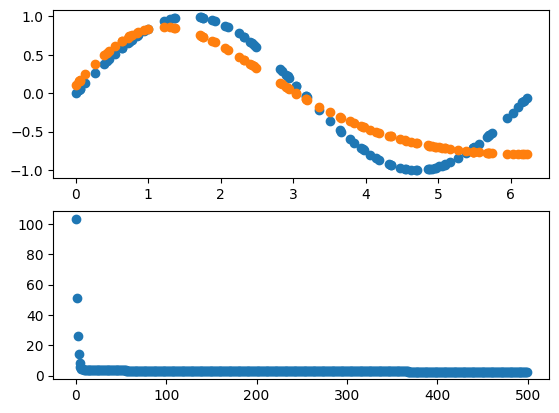

In [85]:
#first testrun
import matplotlib.pyplot as plt
nn = NeuralNetwork([1,20,100,1], activations = ['sigmoid','sigmoid','identity'], loss = 'MSE')
X = 2 * np.pi * np.random.rand(100).reshape(1,-1)
y = np.sin(X)
print(X.shape)
print(y.shape)
print(X)
n_epoch = 500
nn.train(X,y,epochs=n_epoch,batch_size = 64, lr = 0.01)
_,v_s= nn.feedforward(X)
#print(y,X)
fig, ax = plt.subplots(2)
ax[0].scatter(X.flatten(), y.flatten())
ax[0].scatter(X.flatten(),v_s[-1].flatten())
ax[1].scatter(np.arange(n_epoch).flatten(),nn.errors)

loss =22.33719267393051


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: ignored

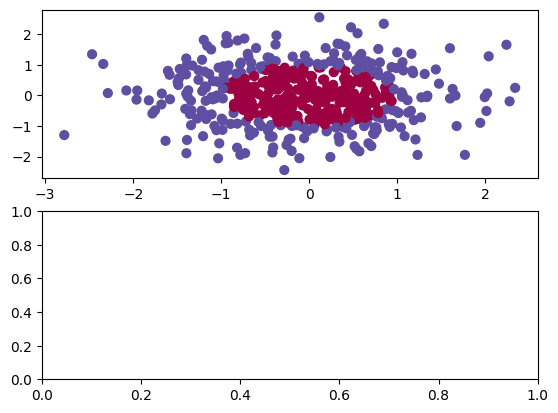

In [92]:
import sklearn.datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

def load_extra_datasets():
    N = 500
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.7, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    return  gaussian_quantiles
gaussian_quantiles= load_extra_datasets()
X, Y = gaussian_quantiles
y = []
X, Y = X.T, Y.reshape(1, Y.shape[0])
Y = Y.reshape(-1, 1)

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform Y to one-hot encoding
Y_onehot = encoder.fit_transform(Y)
# Visualize the data
fig, ax = plt.subplots(2)
ax[0].scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral)
nn = NeuralNetwork([2,20,100,100,2], activations = ['sigmoid','sigmoid','sigmoid','softmax'], loss = 'LCE')
n_epoch = 1000
nn.train(X,Y_onehot.T,epochs=n_epoch,batch_size = 64, lr = 0.01)
pred = nn.predict(X)
#print(pred)
print(pred)
ax[1].scatter(X[0, :], X[1, :], c=pred.reshape(1, Y.shape[0]), s=40, cmap=plt.cm.Spectral)
#print(y,X)

In [5]:
#testing stuff
arr = np.array([1,2,3,4])
print(arr[-1])

4
